In [1]:
import sys
sys.path.append("..")
from pathlib import Path
import numpy as np
from scipy import stats
import importlib
import src.assay_calibration.fit_utils.two_sample.fit
from src.assay_calibration.fit_utils.fit import Fit
importlib.reload(src.assay_calibration.fit_utils.two_sample.fit)
importlib.reload(src.assay_calibration.fit_utils.fit)
from src.assay_calibration.fit_utils.two_sample.fit import single_fit
from src.assay_calibration.fit_utils.two_sample import (density_utils,constraints, optimize)
import scipy.stats as sps
import matplotlib
matplotlib.set_loglevel("warning")
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import trange
import os
sys.path.append(str(Path(os.getcwd()).parent))
from src.assay_calibration.data_utils.dataset import (
    PillarProjectDataframe,
    Scoreset,
    BasicScoreset,
)
import json
import glob

In [2]:
# from src.assay_calibration.data_utils.dataset import (
#     PillarProjectDataframe,
#     Scoreset,
#     BasicScoreset,
# )
# ds = Scoreset.from_json("/data/ross/assay_calibration/scoresets/CALM1_CALM2_CALM3_Weile_2017.json")

In [3]:
# dir(ds)

In [4]:
# ds.scoreset_name

In [5]:
# for sample in ds.samples:
#     print(sample[1])
#     # break

In [6]:
def test_fit(ds, component_range, check_monotonic, init_strategy):
    # Load directly from JSON
    fit = Fit(ds)
    fits, _, _ = fit.run(
                core_limit=10,
                num_fits=20,
                verbose_level=20,
                component_range=component_range,
                bootstrap=False,
                verbose=False,
                max_em_iters=10000,
                check_convergence=False,
                check_monotonic=check_monotonic,
                # submerge_steps=None,#256 if check_monotonic else None,
                init_strategy=init_strategy,
                score_min=ds.scores.min() - 1,
                score_max=ds.scores.max() + 1,
                init_constraint_adjustment_param="skew",
                # kmean_init="k-means++"
            )
    
    return fits, ds

# for dataset_f in glob.glob("/data/ross/assay_calibration/scoresets/*.json"):
    
#     dataset_name = dataset_f.split('/')[-1][:-5]

#     for component_range in ("2-component","3-component"):
#         for monotonicity_contraint in ("no constraint","constraint"):
#             # for init_strategy in ("kmeans","random"):
#             init_strategy = "kmeans"
            
#             fits, ds = test_fit(dataset_f, component_range=[3] if component_range[0] == "3" else [2], 
#                                 check_monotonic=False if monotonicity_contraint[0] == "n" else True, 
#                                 init_strategy=init_strategy)
            
#             fit_results = sorted(fits, key=lambda res: res['likelihoods'][-1], reverse=True)
#             best_fit = fit_results[0]
#             scores = ds.scores
#             sample_assignments = ds.sample_assignments
            
#             score_range = np.linspace(scores.min(), scores.max(), 1000)
#             estimatedDensities = np.array([density_utils.joint_densities(score_range[...,None],
#                                                                          best_fit['component_params'],
#                                                                          sample_weights).squeeze() for sample_weights in best_fit['weights']])
            
#             fig,ax = plt.subplots(3,1, figsize=(12,12))
#             for i in range(3):
#                 ax[i].plot(score_range, estimatedDensities[i].sum(0), label='Estimated', color='C1', linestyle='--')
#                 ax[i].hist(scores[sample_assignments[:,i]], density=True, alpha=0.3, color='gray', label='Data histogram')
#                 ax[i].set_title(f'Sample {i+1}')
#                 ax[i].legend()

In [7]:
all_results = {}

In [ ]:
#### import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# Create output directory if it doesn't exist
output_dir = "/data/ross/assay_calibration/test_experimental_plots_v11"
os.makedirs(output_dir, exist_ok=True)

# Suppress matplotlib debug messages
import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)

n_non_violating_fits_without_constraint = 0
start = False

for dataset_f in (
    glob.glob("/data/ross/assay_calibration/scoresets/*.json")
):
    
    dataset_name = dataset_f.split('/')[-1][:-5]
    if dataset_name == "HMBS_van_Loggerenberg_2023_combined":
        start = True
    if not start:
        continue
    
    print(f"Processing {dataset_name}")

    ds = Scoreset.from_json(dataset_f)
    print(ds)

    sample_names = np.array([sample[1] for sample in ds.samples])
    
    # Create figure with 4x3 subplot grid
    fig, axes = plt.subplots(len(sample_names), 4, figsize=(18, 5*len(sample_names)))
    fig.suptitle(f'Dataset: {dataset_name}', fontsize=16, y=0.995)

    all_results[dataset_name] = {}
    
    plot_idx = 0
    for component_range in ["2-component", "3-component"]:
        for monotonicity_constraint in ["constraint", "no constraint"]:
            # for init_density_fix in ["lambda","sigma"]:
            init_strategy = "random"
            
            # Run the fit
            try:
                fits, ds = test_fit(
                    ds, 
                    component_range=[3] if component_range[0] == "3" else [2], 
                    check_monotonic=False if monotonicity_constraint[0] == "n" else True, 
                    init_strategy=init_strategy
                )
                
                # Get best fit
                # print(fits[0])
                fit_results = sorted(fits, key=lambda res: res['likelihoods'][-1], reverse=True)
                times_submerged = [results['times_submerged'] for results in fit_results]
                print(dataset_name, component_range, monotonicity_constraint, times_submerged)
                best_fit = fit_results[0]
                best_init = "MoM" if best_fit['kmeans'] == "method_of_moments" else "KM"
                xlims = best_fit['xlims']
                scores = ds.scores
                sample_assignments = ds.sample_assignments
    
                
                all_results[dataset_name][(component_range, monotonicity_constraint)] = fit_results 
    
                # Calculate densities
                score_range = np.linspace(scores.min(), scores.max(), 1000)
                estimatedDensities = np.array([
                    density_utils.joint_densities(
                        score_range[..., None],
                        best_fit['component_params'],
                        sample_weights
                    ).squeeze() for sample_weights in best_fit['weights']
                ])
                
                # Check if density constraint violated
                fit_violates_constraint = constraints.multicomponent_density_constraint_violated(best_fit['component_params'], xlims)
                if monotonicity_constraint == "no constraint" and fit_violates_constraint:
                    n_non_violating_fits_without_constraint += 1
                fit_violates_constraint = "violates" if fit_violates_constraint else "not violates"
                
                # Plot for each sample (3 columns)
                for i in range(len(estimatedDensities)):
                    ax = axes[i, plot_idx]
                    
                    # Plot estimated density
                    ax.plot(score_range, estimatedDensities[i].sum(0), 
                           label='Estimated', color='C1', linestyle='-', linewidth=2)
                    
                    # Plot histogram of actual data
                    if i < sample_assignments.shape[1] and sample_assignments[:, i].sum() > 0:
                        ax.hist(scores[sample_assignments[:, i]], 
                               bins=30, density=True, alpha=0.3, 
                               color='gray', label='Data')
                    
                    # Set labels and title
                    if plot_idx == 0:
                        ax.set_ylabel(sample_names[i], 
                                     fontsize=12, fontweight='bold')
                    
                    if i == 0:
                        ax.set_title(f'{component_range}, {monotonicity_constraint}, {best_init}, {fit_violates_constraint}', fontsize=12)
                    
                    if i == len(estimatedDensities) - 1:
                        ax.set_xlabel('Score', fontsize=10)
                    
                    ax.legend(loc='upper right', fontsize=8)
                    ax.grid(True, alpha=0.2)
                    
                    # Add likelihood value as text
                    likelihood = best_fit['likelihoods'][-1]
                    ax.text(0.02, 0.98, f'LL: {likelihood:.3f}, n={len(scores[sample_assignments[:, i]])}', 
                           transform=ax.transAxes, fontsize=12,
                           verticalalignment='top')
                
            except Exception as e:
                print(f"  Error with {component_range}, {monotonicity_constraint}: {e}")
                # Create empty plots with error message
                for i in range(len(estimatedDensities)):
                    ax = axes[i, plot_idx]
                    ax.text(0.5, 0.5, f'Error:\n{str(e)[:30]}...', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_xticks([])
                    ax.set_yticks([])

                    if i == 0:
                        ax.set_title(f'{component_range}, {monotonicity_constraint}, {best_init}, {fit_violates_constraint}', fontsize=12)
                    
                    if plot_idx == 0:
                        ax.set_ylabel(sample_names[i], 
                                     fontsize=12, fontweight='bold')
                    
                    if i == len(estimatedDensities) - 1:
                        ax.set_xlabel('Score', fontsize=10)
            
            plot_idx += 1
    
    # Adjust layout and save
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    output_path = f"{output_dir}/{dataset_name}.png"
    plt.savefig(output_path, dpi=100, bbox_inches='tight')
    plt.close()
    
    print(f"  Saved to {output_path}")

print("All plots saved!")

Processing HMBS_van_Loggerenberg_2023_combined
HMBS_van_Loggerenberg_2023_combined: 19977 total variants
	Pathogenic/Likely Pathogenic: 45 variants
	Benign/Likely Benign: 4 variants
	gnomAD: 387 variants
	Synonymous: 286 variants

HMBS_van_Loggerenberg_2023_combined 3-component no constraint [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
HMBS_van_Loggerenberg_2023_combined 3-component constraint [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [25]:
import json

data = [
    {
        "iteration": 827,
        "likelihood": {
            "old": -0.4476419336680867,
            "new": -0.4476464459503779,
            "decrease": 4.51e-06,
            "relative_decrease": 1.01e-05
        },
        "numerical_rounding": True,
        "params": {
            "old": [
                [-121.42186004396987, 0.6004910252635637, 1.3746372559748896],
                [-4.0579815715731, 1.2142388476797852, 0.48644237478812646]
            ],
            "new": [
                [-111.01780766532288, 0.6005171962532104, 1.3696170331673694],
                [-4.032388070458339, 1.2140267755751089, 0.4835523850874678]
            ]
        }
    },
    {
        "iteration": 828,
        "likelihood": {
            "old": -0.4476464459503779,
            "new": -0.4476503458709355,
            "decrease": 3.90e-06,
            "relative_decrease": 8.71e-06
        },
        "numerical_rounding": True,
        "params": {
            "old": [
                [-111.01780766532288, 0.6005171962532104, 1.3696170331673694],
                [-4.032388070458339, 1.2140267755751089, 0.4835523850874678]
            ],
            "new": [
                [-100.61357758942951, 0.6005575982926298, 1.3638718851743319],
                [-4.002726588029325, 1.2137830055940555, 0.480215484244024]
            ]
        }
    }
]

# Save to JSON file
with open('iteration_logs.json', 'w') as f:
    json.dump(data, f, indent=2)

In [18]:
submerge_times = {'2-component':[],'3-component':[]}
n_fits_satisfy = {'2-component':0,'3-component':0}
for dataset in all_results:
    for key in all_results[dataset]:
        fit_results = sorted(all_results[dataset][key], key=lambda res: len(res['times_submerged']), reverse=True)
        for fit in fit_results:
            if fit['component_params'] is not None and constraints.multicomponent_density_constraint_violated(fit['component_params'],
                                                                      fit['xlims']):
                if len(fit['times_submerged']) != 0 and key[1] == 'no constraint':
                    n_fits_satisfy[key[0]] += 1
                submerge_times[key[0]].extend([item for item in fit['times_submerged']])
                # print(dataset, key, [item for item in fit['times_submerged']])
            
submerge_times['2-component'] = np.array(submerge_times['2-component'])
submerge_times['3-component'] = np.array(submerge_times['3-component'])
n_fits_satisfy

{'2-component': 19, '3-component': 107}

In [12]:
submerge_times

{'2-component': array([12, 11,  1,  3,  3,  3,  3,  3,  4,  1,  6, 15,  7,  2,  1, 13, 16,
        22, 16]),
 '3-component': array([ 189,    8,   67,   86,   65,   74,   75,   77,   15,   17,   18,
          18,   11,   19,   16,   16,   17,   16,   30,   16,   15,    1,
           1,    1,    1,    1,   11,    1,    4,    1,    1,    1,    1,
          14,    3,    3,   14,   14,    3,    6,    3,   14,    5,    2,
          14,   14,   14,    3,    4,    2,   23, 1884,   19, 1160,   14,
        2209, 2624,  684, 1586,  792, 1007,   22, 2095,   24,   23,    1,
         152,    2,  109,   84,   70,  108,  145,  114,    2,   44,  146,
         151,    1,    1,    2,    1,    2,    3,    1,  222,  301,    2,
           9,   35,  293,  180,   97,  333,    7,   85,  302,  281,  209,
        1637, 2679, 1715,   95,  414,    1,   59,   10,   71,    1,   38,
           2,   36,   80,   10,  349,   24,  106,    4,  336,  159])}

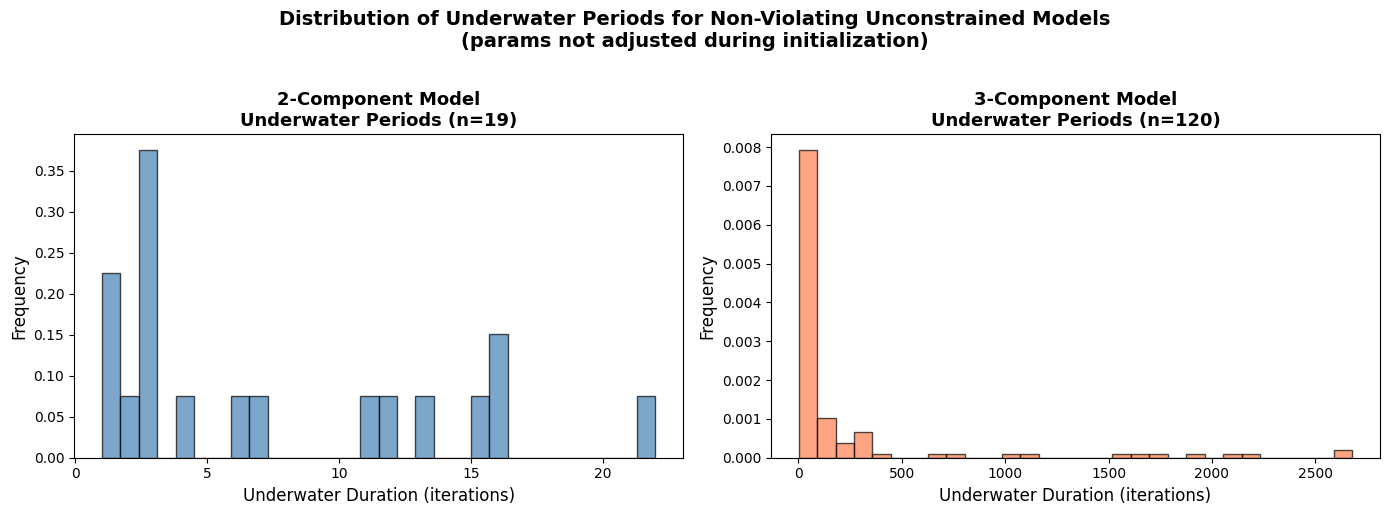

In [13]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for 2-component
data_2comp = submerge_times['2-component']
data_2comp_nonzero = data_2comp[data_2comp > 0]  # Remove zeros for log scale

axes[0].hist(data_2comp_nonzero, bins=30,
             edgecolor='black', alpha=0.7, color='steelblue', density=True)
# axes[0].set_xscale('log')
axes[0].set_xlabel('Underwater Duration (iterations)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title(f'2-Component Model\nUnderwater Periods (n={len(data_2comp_nonzero)})', fontsize=13, fontweight='bold')
# axes[0].grid(True, alpha=0.3, which='both')

# Plot for 3-component
data_3comp = submerge_times['3-component']
data_3comp_nonzero = data_3comp[data_3comp > 0]  # Remove zeros for log scale

axes[1].hist(data_3comp_nonzero, bins=30,
             edgecolor='black', alpha=0.7, color='coral', density=True)
# axes[1].set_xscale('log')
axes[1].set_xlabel('Underwater Duration (iterations)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'3-Component Model\nUnderwater Periods (n={len(data_3comp_nonzero)})', fontsize=13, fontweight='bold')
# axes[1].grid(True, alpha=0.3, which='both')

# Add statistics annotations
# for ax, data, name in zip(axes, [data_2comp_nonzero, data_3comp_nonzero], ['2-comp', '3-comp']):
#     ax.axvline(np.median(data), color='red', linestyle='--', alpha=0.7, label=f'Median: {np.median(data):.0f}')
#     ax.legend(loc='upper right')

plt.suptitle('Distribution of Underwater Periods for Non-Violating Unconstrained Models\n(params not adjusted during initialization)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [12]:
# for dataset_f in glob.glob("/data/ross/assay_calibration/scoresets/KCNH2_O_Neill_2024_surface_expression*.json"):
#     dataset_name = dataset_f.split('/')[-1][:-5]
#     print(f"Processing {dataset_name}")

#     ds = Scoreset.from_json(dataset_f)
#     print(ds)

#     sample_names = np.array([sample[1] for sample in ds.samples])
    
#     # Create figure with 4x3 subplot grid
#     fig, axes = plt.subplots(len(sample_names), 4, figsize=(18, 5*len(sample_names)))
#     fig.suptitle(f'Dataset: {dataset_name}', fontsize=16, y=0.995)
    
#     for i,component_range in enumerate(["2-component", "3-component"]):
#         for monotonicity_constraint in ["constraint", "no constraint"]:
#             if (component_range,monotonicity_constraint) not in all_results[dataset_name]:
#                 continue
#             best_fit = all_results[dataset_name][(component_range,monotonicity_constraint)]
        
#             best_init = "MoM" if best_fit['kmeans'] == "method_of_moments" else "KM"
#             xlims = best_fit['xlims']
#             scores = ds.scores
#             sample_assignments = ds.sample_assignments


#             # Calculate densities
#             score_range = np.linspace(scores.min(), scores.max(), 1000)
#             estimatedDensities = np.array([
#                 density_utils.joint_densities(
#                     score_range[..., None],
#                     best_fit['component_params'],
#                     sample_weights
#                 ).squeeze() for sample_weights in best_fit['weights']
#             ])
            
#             # Check if density constraint violated
#             fit_violates_constraint = constraints.multicomponent_density_constraint_violated(best_fit['component_params'], xlims)
#             if monotonicity_constraint == "no constraint" and fit_violates_constraint:
#                 n_non_violating_fits_without_constraint += 1
#             fit_violates_constraint = "violates" if fit_violates_constraint else "not violates"
            
#             # Plot for each sample (3 columns)
#             for i in range(len(estimatedDensities)):
#                 ax = axes[i, plot_idx]
                
#                 # Plot estimated density
#                 ax.plot(score_range, estimatedDensities[i].sum(0), 
#                        label='Estimated', color='C1', linestyle='-', linewidth=2)
                
#                 # Plot histogram of actual data
#                 if i < sample_assignments.shape[1] and sample_assignments[:, i].sum() > 0:
#                     ax.hist(scores[sample_assignments[:, i]], 
#                            bins=30, density=True, alpha=0.3, 
#                            color='gray', label='Data')
                
#                 # Set labels and title
#                 if plot_idx == 0:
#                     ax.set_ylabel(sample_names[i], 
#                                  fontsize=12, fontweight='bold')
                
#                 if i == 0:
#                     ax.set_title(f'{component_range}, {monotonicity_constraint}, {best_init}, {fit_violates_constraint}', fontsize=12)
                
#                 if i == len(estimatedDensities) - 1:
#                     ax.set_xlabel('Score', fontsize=10)
                
#                 ax.legend(loc='upper right', fontsize=8)
#                 ax.grid(True, alpha=0.2)
                
#                 # Add likelihood value as text
#                 likelihood = best_fit['likelihoods'][-1]
#                 ax.text(0.02, 0.98, f'LL: {likelihood:.3f}, n={len(scores[sample_assignments[:, i]])}', 
#                        transform=ax.transAxes, fontsize=12,
#                        verticalalignment='top')
            
        
#         plot_idx += 1

# # Adjust layout and save
# plt.tight_layout(rect=[0, 0, 1, 0.99])


In [21]:
n_non_violating_fits_without_constraint = [0,0]
n_violating_fits_without_constraint = [0,0]
for dataset_f in glob.glob("/data/ross/assay_calibration/scoresets/*.json"):
    dataset_name = dataset_f.split('/')[-1][:-5]
    for i,component_range in enumerate(["2-component", "3-component"]):
        for monotonicity_constraint in ["constraint", "no constraint"]:
            if (component_range,monotonicity_constraint) not in all_results[dataset_name]:
                continue
            params = all_results[dataset_name][(component_range,monotonicity_constraint)]['component_params']
            xlims = all_results[dataset_name][(component_range,monotonicity_constraint)]['xlims']
            fit_violates_constraint = constraints.multicomponent_density_constraint_violated(params, xlims)
            if monotonicity_constraint == "no constraint" and fit_violates_constraint:
                n_violating_fits_without_constraint[i] += 1
            elif monotonicity_constraint == "no constraint":
                n_non_violating_fits_without_constraint[i] += 1

for i,component_range in enumerate(["2-component", "3-component"]):
    print(f'{component_range}: {100*n_non_violating_fits_without_constraint[i]/(n_non_violating_fits_without_constraint[i]+n_violating_fits_without_constraint[i]):.1f}% ({n_non_violating_fits_without_constraint[i]}/{n_non_violating_fits_without_constraint[i]+n_violating_fits_without_constraint[i]}) did not violate the constraint.')

                

2-component: 44.4% (36/81) did not violate the constraint.
3-component: 12.8% (10/78) did not violate the constraint.


In [12]:
temp = 0

temp

166

In [9]:
ds = Scoreset.from_json('/data/ross/assay_calibration/scoresets/TPK1_Weile_2017.json')

# constraints.multicomponent_density_constraint_violated(
#     all_results['BAP1_Waters_2024'][('3-component','constraint')]['component_params'],
#     (ds.scores.min(), ds.scores.max())
# ), all_results['BAP1_Waters_2024'][('3-component','constraint')]['component_params']

array([ 0.77115825,  0.98333398, -0.16921046, ...,  0.85483201,
        0.22272929,  0.61611011], shape=(3422,))

In [13]:
ds.scores[ds.sample_assignments[:,3]], ds.scores[ds.sample_assignments[:,3]].shape

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1.])

In [ ]:
# 'HMBS_van_Loggerenberg_2023_combined', 'TP53_Fortuno_2021_Kato_meta' truth value of arr
# 'KCNH2_Jiang_2022', 'KCNH2_O_Neill_2024_surface_expression' ll decreased consistently & xlims



In [8]:
constraints.multicomponent_density_constraint_violated(best_fit['component_params'],
                                                       score_range[[0,-1]])

True

In [9]:
best_fit.keys()

dict_keys(['component_params', 'weights', 'likelihoods', 'history', 'kmeans'])

In [10]:
best_fit['component_params']

[(-8.553172420104763, 0.7949678509378952, 0.24375170761527565),
 (-1.4489019235176928, 0.9296749533938731, 0.04216918377139136),
 (-7.860341896888932e-05, 1.003620376681616, 0.020770124957920067)]

In [11]:
scores.min(),scores.max()

(np.float64(-0.483185729440366), np.float64(1.36169269063829))

In [12]:
# Iteration 9618: Likelihood DECREASED by 1.96e-06 (relative: 3.51e-06) - algorithmic issue